In [19]:
# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

warnings.filterwarnings('ignore')

In [20]:
import os
# List of genres
genres = ['Blues', 'Classical', 'Country', 'Disco', 'Hiphop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
# Load the corresponding datasets for the selected genres
file_names = [f'../GeneratedData/3secondsData/{genre}_dataset.csv' for genre in genres]
data_frames = []

for file_name in file_names:
    if os.path.exists(file_name):
        data_frames.append(pd.read_csv(file_name))
    else:
        print(f"Warning: {file_name} not found.")

# Concatenate all genre datasets into a single DataFrame
data = pd.concat(data_frames, ignore_index=True)

# Drop specified columns if they exist
columns_to_drop = ['length', 'filename', 'Genre', 'TrackID']
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])
data = data.iloc[0:, 1:] 
data.head()



,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.095008,0.185607,0.004235,2309.576775,93030.022104,2429.792516,51723.402280,4856.648325,4.736177e+05,0.102828,...,51.344734,-0.174905,55.654100,2.510336,56.786434,-0.214017,58.3173,6.0806,91.186195,Blues
1,0.084437,0.158308,0.001943,2470.299940,1150638.101858,2433.543715,147715.927307,5104.445801,2.473978e+06,0.117646,...,41.391350,-5.370171,28.830446,-3.635559,31.478884,-3.941624,30.230938,1.690726,40.74665,Blues
2,0.079636,0.192385,0.001355,1455.887998,86219.761106,2057.615196,44640.975001,2814.886569,6.749792e+05,0.057617,...,51.115437,-5.485735,34.861324,-0.703013,21.41585,-2.639422,18.214354,3.585274,27.473557,Blues
3,0.071975,0.329864,0.001105,3050.314322,87162.367945,2837.614893,22244.267512,6540.047889,3.615928e+05,0.155022,...,26.771856,-0.103712,45.055164,4.611008,43.10473,-1.767525,43.30031,0.050157,35.812057,Blues
4,0.081494,0.366179,0.001296,1649.309448,57535.475159,2179.496962,57149.244176,3387.172852,5.985052e+05,0.063161,...,59.062830,-10.666750,21.608093,2.774094,26.795692,-7.628335,17.076103,1.692927,20.737106,Blues


In [22]:
y = data['label'] # genre variable.
X = data.drop(columns=['label']) #select all columns but not the labels


X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()
y = y[X.index] 

# Normalize so everything is on the same scale. 

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

30% Testing Data, 70% Training Data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [28]:
# Accuracy of models

def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy of', title, ':', round(accuracy_score(y_test, preds), 5))

# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Testing more models

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Fit and transform y_train and y_test
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

def model_assess_encoded(model, X_train, y_train, X_test, y_test, title="Default"):
    # Train model with encoded labels
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds_decoded = le.inverse_transform(preds)
    print(f"{title} - Accuracy:", round(accuracy_score(y_test, preds), 5))

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess_encoded(xgb, X_train, y_train_encoded, X_test, y_test_encoded, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess_encoded(xgbrf, X_train, y_train_encoded, X_test, y_test_encoded, "Cross Gradient Booster (Random Forest)")

Accuracy of Naive Bayes : 0.38795
Accuracy of Stochastic Gradient Descent : 0.43213
Accuracy of KNN : 0.70361
Accuracy of Decission trees : 0.50924
Accuracy of Random Forest : 0.6502
Accuracy of Support Vector Machine : 0.53976
Accuracy of Logistic Regression : 0.49639
Accuracy of Neural Nets : 0.45502
Cross Gradient Booster - Accuracy: 0.78635
Cross Gradient Booster (Random Forest) - Accuracy: 0.58353


In [60]:
# Print the label encoding mapping
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label encoding mapping:")
print(label_mapping)


Label encoding mapping:
{'Blues': 0, 'Country': 1, 'Electronic': 2, 'Folk': 3, 'Jazz': 4, 'Latin': 5, 'Metal': 6, 'Pop': 7, 'Rap': 8, 'Reggae': 9, 'Rock': 10}


Accuracy : 0.78635 



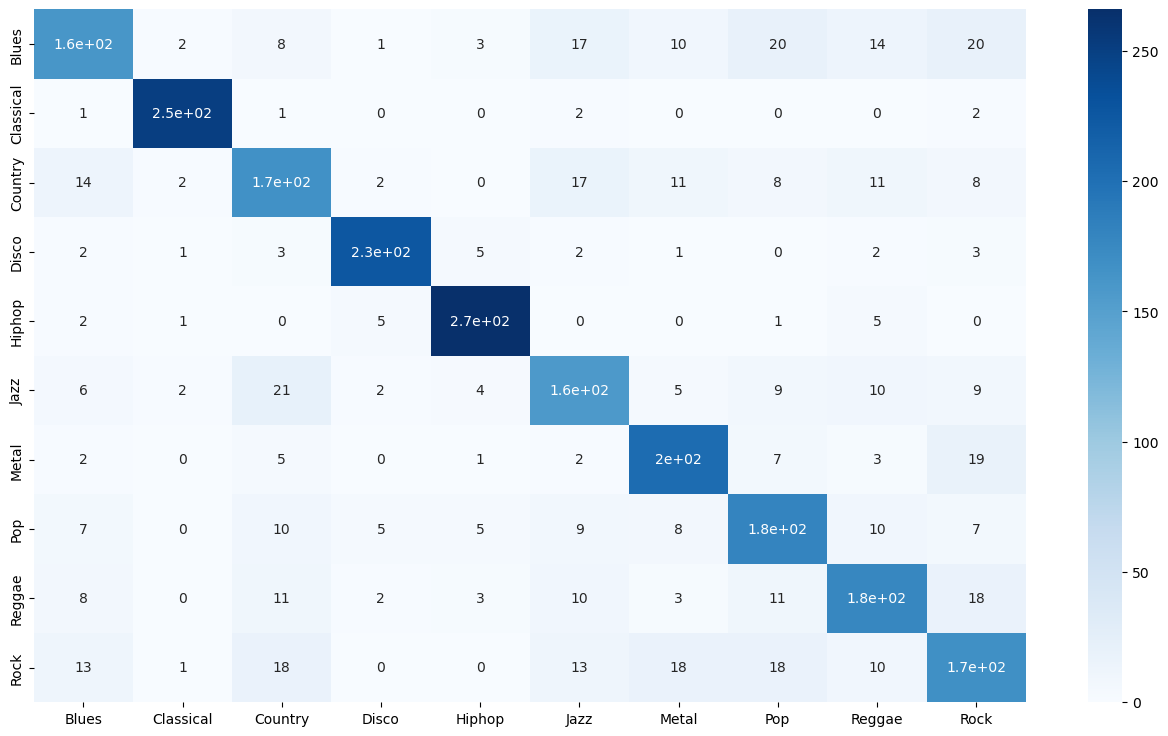

In [30]:
# Final model, XGB had best accuracy
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train_encoded)

preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test_encoded, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test_encoded, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, xticklabels=genres, yticklabels=genres) 
plt.show()

Accuracy: 0.82054


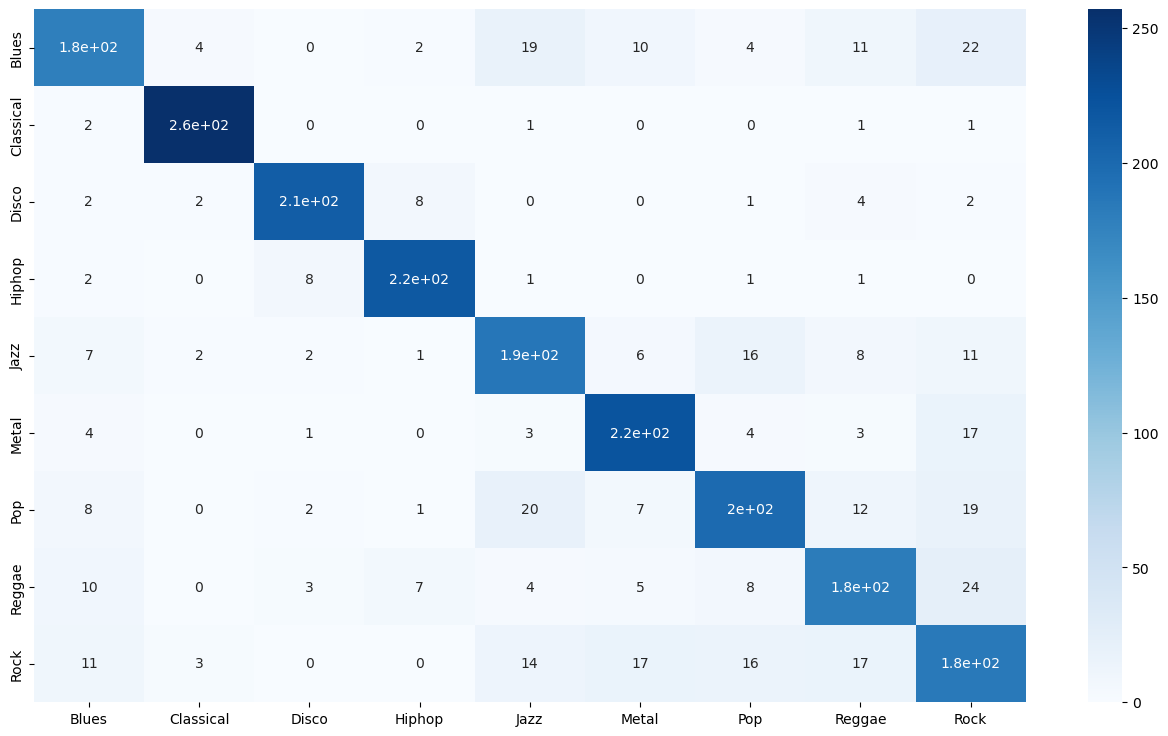

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from xgboost import XGBClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt

# List of genres
genres = ['Blues', 'Classical', 'Disco', 'Hiphop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']

# Load the corresponding datasets for the selected genres
file_names = [f'../GeneratedData/3secondsData/{genre}_dataset.csv' for genre in genres]
data_frames = []

for file_name in file_names:
    if os.path.exists(file_name):
        data_frames.append(pd.read_csv(file_name))
    else:
        print(f"Warning: {file_name} not found.")

if not data_frames:
    print(f"No datasets found for {genres}. Exiting.")
else:
    # Concatenate all genre datasets into a single DataFrame
    data = pd.concat(data_frames, ignore_index=True)
    
    # Drop specified columns if they exist
    columns_to_drop = ['length', 'filename', 'Genre', 'TrackID']
    data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])
    
    # Separate features and target (label)
    y = data['label']
    X = data.drop(columns=['label'])

    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.dropna()
    y = y[X.index]  # Align y with the filtered X

    # Normalize X
    min_max_scaler = MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(X)
    X = pd.DataFrame(np_scaled, columns=X.columns)

    # Split the data (20-30% testing split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Encode the labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    # Define the XGBoost model with given hyperparameters
    xgb = XGBClassifier(n_estimators=10000, learning_rate=0.005, random_state=42)

    # Train the model
    xgb.fit(X_train, y_train_encoded)
    preds = xgb.predict(X_test)

    # Evaluate accuracy
    print('Accuracy:', round(accuracy_score(y_test_encoded, preds), 5))

    # Confusion Matrix
    confusion_matr = confusion_matrix(y_test_encoded, preds)
    plt.figure(figsize=(16, 9))
    sns.heatmap(confusion_matr, cmap="Blues", annot=True, xticklabels=genres, yticklabels=genres)
    plt.savefig("ConfusionMatrix_CombinedDataData_25p_10000_0_005_noCountry")
    plt.show()


In [75]:
# Display the number of rows in X
print(f"Number of rows in X: {X.shape[0]}")


Number of rows in X: 9959


Accuracy: 0.78313


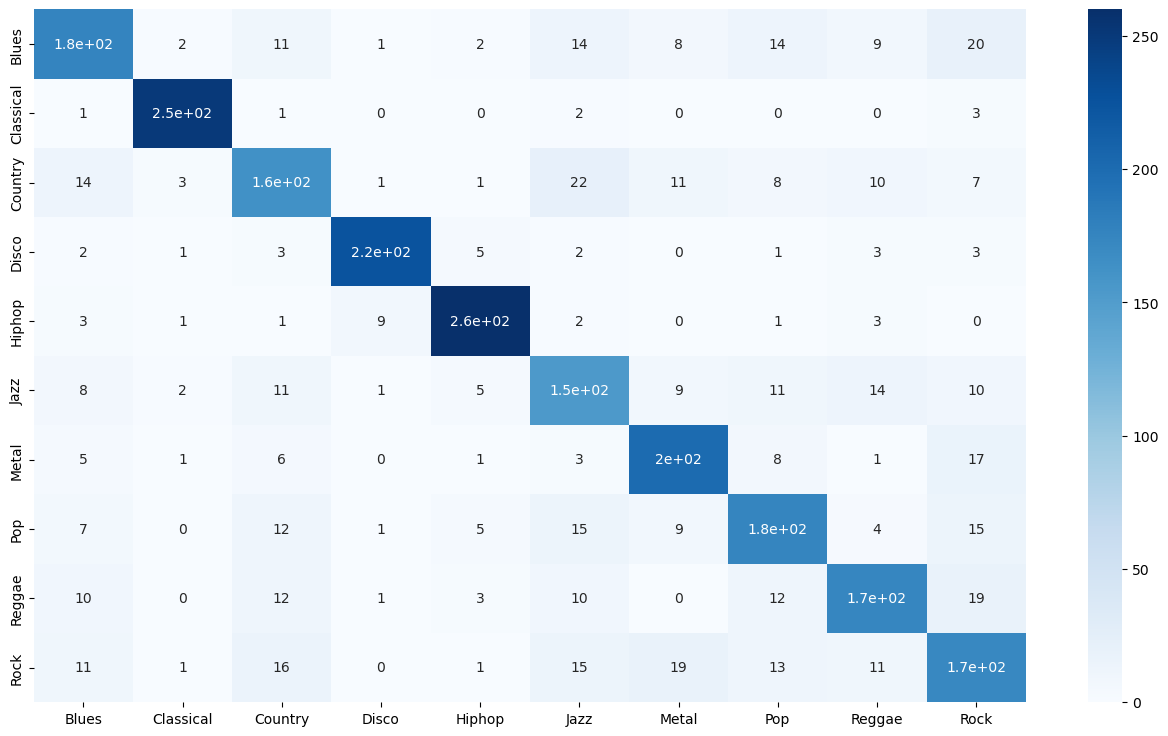

Model saved as 'xgb_model_2500_0_01_25p.pkl'
Label encoder saved as 'label_encoder_25p.pkl'


In [93]:
# 10 Genres

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from xgboost import XGBClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


# List of genres
genres = ['Blues', 'Classical', 'Country', 'Disco', 'Hiphop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
# Load the corresponding datasets for the selected genres
file_names = [f'../GeneratedData/3secondsData/{genre}_dataset.csv' for genre in genres]
data_frames = []

for file_name in file_names:
    if os.path.exists(file_name):
        data_frames.append(pd.read_csv(file_name))
    else:
        print(f"Warning: {file_name} not found.")

if not data_frames:
    print(f"No datasets found for {genres}. Exiting.")
else:
    # Concatenate all genre datasets into a single DataFrame
    data = pd.concat(data_frames, ignore_index=True)
    
    # Drop specified columns if they exist
    columns_to_drop = ['length', 'filename', 'Genre', 'TrackID']
    data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])
    
    # Separate features and target (label)
    y = data['label']
    X = data.drop(columns=['label'])

    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.dropna()
    y = y[X.index]  # Align y with the filtered X

    # Normalize X
    min_max_scaler = MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(X)
    X = pd.DataFrame(np_scaled, columns=X.columns)

    # Split the data (20-30% testing split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Encode the labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    # Define the XGBoost model with given hyperparameters
    xgb = XGBClassifier(n_estimators=4000, learning_rate=0.01, random_state=42)

    # Train the model
    xgb.fit(X_train, y_train_encoded)
    preds = xgb.predict(X_test)

    # Evaluate accuracy
    print('Accuracy:', round(accuracy_score(y_test_encoded, preds), 5))

    # Confusion Matrix
    confusion_matr = confusion_matrix(y_test_encoded, preds)
    plt.figure(figsize=(16, 9))
    sns.heatmap(confusion_matr, cmap="Blues", annot=True, xticklabels=genres, yticklabels=genres)
    plt.savefig("ConfusionMatrix_CombinedDataData_30p_50000_0_005")
    plt.show()

    # Save the model to a file
    joblib.dump(xgb, "xgb_model_4000_0_01_25p.pkl")
    print("Model saved as 'xgb_model_2500_0_01_25p.pkl'")

    # Save the LabelEncoder
    joblib.dump(le, "label_encoder_4000_0_01_25p.pkl")
    print("Label encoder saved as 'label_encoder_25p.pkl'")


In [91]:
# Dump Model params

import joblib

# Save the model
joblib.dump(xgb, "xgb_model_5000_0_01_25p.pkl")
print("Model saved as 'xgb_model_5000_0_01.pkl'")

# Save the LabelEncoder
joblib.dump(le, "label_encoder_25p.pkl")
print("Label encoder saved as 'label_encoder_25p.pkl'")


Model saved as 'xgb_model_5000_0_01.pkl'
Label encoder saved as 'label_encoder_25p.pkl'


Accuracy: 0.71267


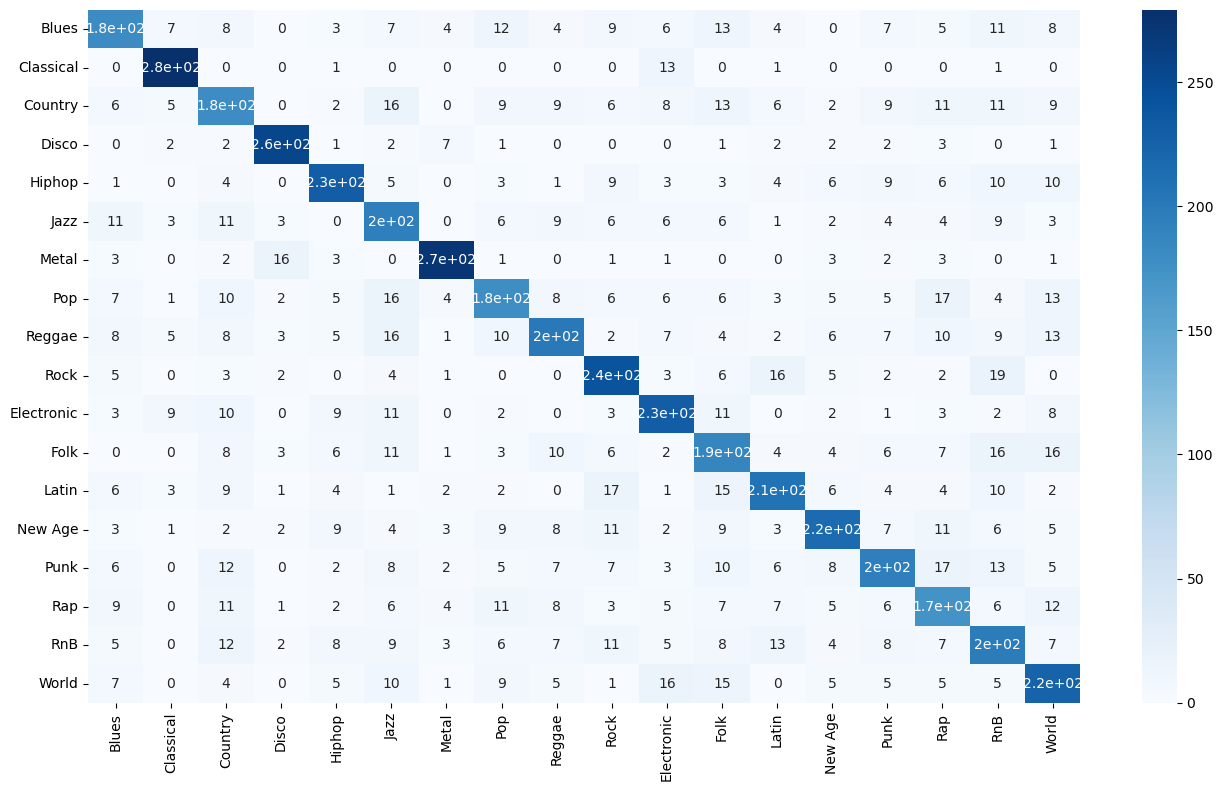

In [ ]:
# ALL Genres:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from xgboost import XGBClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt

# List of genres
genres = ['Blues', 'Classical', 'Country', 'Disco', 'Hiphop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock','Electronic','Folk','Latin','New Age','Punk','Rap','RnB']
# Load the corresponding datasets for the selected genres
file_names = [f'../GeneratedData/3secondsData/{genre}_dataset.csv' for genre in genres]
data_frames = []

for file_name in file_names:
    if os.path.exists(file_name):
        data_frames.append(pd.read_csv(file_name))
    else:
        print(f"Warning: {file_name} not found.")

if not data_frames:
    print(f"No datasets found for {genres}. Exiting.")
else:
    # Concatenate all genre datasets into a single DataFrame
    data = pd.concat(data_frames, ignore_index=True)
    
    # Drop specified columns if they exist
    columns_to_drop = ['length', 'filename', 'Genre', 'TrackID']
    data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])
    
    # Separate features and target (label)
    y = data['label']
    X = data.drop(columns=['label'])

    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.dropna()
    y = y[X.index]  # Align y with the filtered X

    # Normalize X
    min_max_scaler = MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(X)
    X = pd.DataFrame(np_scaled, columns=X.columns)

    # Split the data (20-30% testing split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Encode the labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    # Define the XGBoost model with given hyperparameters
    xgb = XGBClassifier(n_estimators=10000, learning_rate=0.01, random_state=42)

    # Train the model
    xgb.fit(X_train, y_train_encoded)
    preds = xgb.predict(X_test)

    # Evaluate accuracy
    print('Accuracy:', round(accuracy_score(y_test_encoded, preds), 5))

    # Confusion Matrix
    confusion_matr = confusion_matrix(y_test_encoded, preds)
    plt.figure(figsize=(16, 9))
    sns.heatmap(confusion_matr, cmap="Blues", annot=True, xticklabels=genres, yticklabels=genres)
    plt.savefig("ConfusionMatrix_CombinedDataData_30p_1000_0_01")
    plt.show()


Feature Importances (Percentage):
perceptr_var: 7.88%
chroma_stft_var: 5.68%
mfcc5_var: 3.91%
harmony_var: 3.37%
chroma_stft_mean: 2.92%
mfcc10_mean: 2.43%
spectral_bandwidth_mean: 2.39%
mfcc7_var: 2.21%
rms_var: 2.21%
rms_mean: 2.17%
mfcc2_mean: 2.13%
tempo: 2.12%
mfcc1_var: 2.10%
mfcc8_mean: 2.09%
mfcc3_mean: 1.98%
perceptr_mean: 1.90%
mfcc6_mean: 1.83%
rolloff_mean: 1.82%
mfcc9_mean: 1.76%
mfcc1_mean: 1.75%
spectral_centroid_var: 1.75%
mfcc4_mean: 1.64%
spectral_centroid_mean: 1.62%
zero_crossing_rate_mean: 1.59%
mfcc12_mean: 1.56%
mfcc11_mean: 1.52%
mfcc3_var: 1.51%
mfcc7_mean: 1.46%
mfcc6_var: 1.45%
harmony_mean: 1.41%
mfcc17_mean: 1.36%
mfcc4_var: 1.31%
mfcc5_mean: 1.29%
mfcc14_mean: 1.27%
rolloff_var: 1.26%
spectral_bandwidth_var: 1.25%
mfcc20_mean: 1.23%
mfcc13_mean: 1.20%
zero_crossing_rate_var: 1.20%
mfcc15_mean: 1.19%
mfcc16_mean: 1.15%
mfcc11_var: 1.15%
mfcc2_var: 1.14%
mfcc10_var: 1.11%
mfcc8_var: 1.09%
mfcc20_var: 1.09%
mfcc18_mean: 1.07%
mfcc19_mean: 1.07%
mfcc19_var: 1.

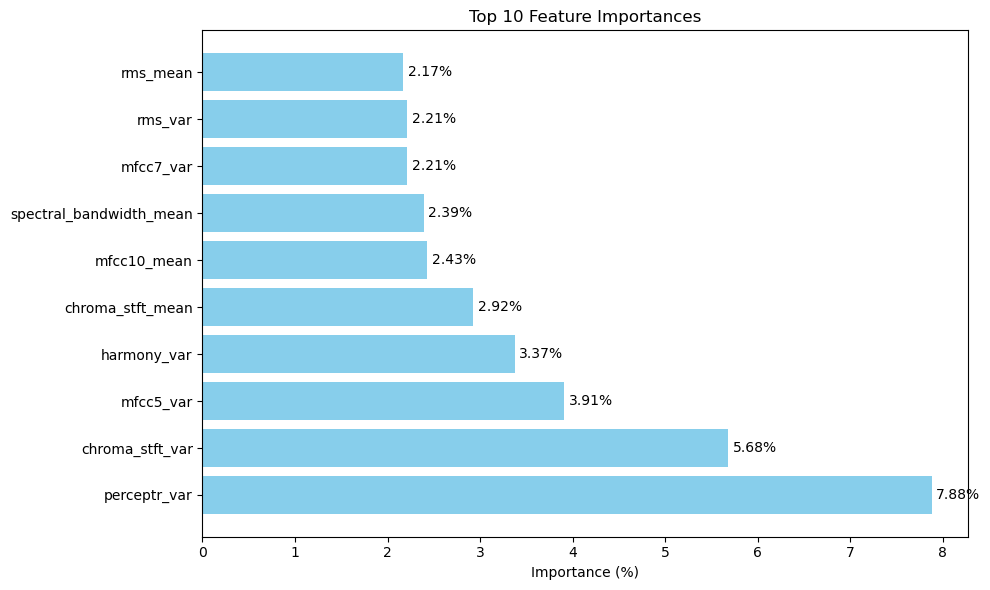

In [16]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the model
model = joblib.load("../frontend/25p_4000_0_01_Model/xgb_model_4000_0_01_25p.pkl")

# Check if the model has feature importances
if hasattr(model, "feature_importances_"):
    feature_importances = model.feature_importances_
else:
    raise AttributeError("The loaded model does not have feature importances.")

# Get feature names from the model
feature_names = model.feature_names_in_

# Calculate the importance percentage for each feature
importance_percentages = 100 * feature_importances / np.sum(feature_importances)

# Create a DataFrame to display feature importances as percentages
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance (%)": importance_percentages
}).sort_values(by="Importance (%)", ascending=False)

# Print the importance of each feature
print("Feature Importances (Percentage):")
for index, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance (%)']:.2f}%")

# Select the top 10 most important features
top_10_features = importance_df.head(10)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_features["Feature"], top_10_features["Importance (%)"], color='skyblue')

# Annotate the bars with the importance percentage
for bar in bars:
    width = bar.get_width()
    plt.text(width+0.05, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}%', va='center', ha='left', color='black')

plt.xlabel('Importance (%)')
plt.title('Top 10 Feature Importances')

# Save the plot as an image
plt.tight_layout()
plt.savefig("top_10_feature_importances.png")

# Display the plot
plt.show()
